In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from wmfdata import charting, hive

You are using wmfdata v1.0.3, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


In [2]:
# UPDATE FOR NEW MONTH!
# Start included, end excluded.
# Have to set the end back a couple of months to ensure we only get uncensored data.
# To-do: We take the metric month and look backwards. But this results in censored data
# for months under 30 days (February).

#START = '2019-05'
#END = '2019-06'
#MWH_SNAPSHOT = '2019-07'

last_month = datetime.date.today().replace(day=1) - datetime.timedelta(days=1)
last_two_month = datetime.date.today().replace(day=1) - datetime.timedelta(days= 35)
last_three_month = datetime.date.today().replace(day=1) - datetime.timedelta(days= 70)


START = last_three_month.strftime("%Y-%m")
END = last_two_month.strftime("%Y-%m")
MWH_SNAPSHOT = last_month.strftime("%Y-%m") # The latest available mediawiki_history snapshot

In [3]:
%matplotlib inline
charting.set_mpl_style()

# Update table

In [4]:
# Create the table if necessary
hive.run(
"""
create table if not exists cchen.new_editor_retention (
    user_name string,
    wiki string,
    user_id bigint,
    cohort string,
    1st_month_edits bigint,
    2nd_month_edits bigint
)
-- This allows us to delete data later on (e.g. in case of duplicate inserts)
TBLPROPERTIES ("transactional"="true")
"""
)

In [5]:
hive.run(
    """
    insert into table cchen.new_editor_retention
    select 
        1st_month.user_name as user_name,
        1st_month.wiki as wiki,
        1st_month.user_id as user_id,
        1st_month.cohort as cohort,
        1st_month.edits as 1st_month_edits,
        coalesce(2nd_month.edits, 0) as 2nd_month_edits
    from (
        select
            event_user_text as user_name,
            wiki_db as wiki,
            event_user_id as user_id,
            substr(event_user_creation_timestamp, 0, 7) as cohort,
            count(*) as edits
        from wmf.mediawiki_history
        where
            snapshot = "{snapshot}" and
            event_entity = "revision" and
            event_type = "create" and
            not event_user_is_created_by_system and
            event_user_creation_timestamp between "{start}" and "{end}" and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
        group by event_user_text, event_user_id, event_user_creation_timestamp, wiki_db
        ) 1st_month
    left join (
        select
            event_user_text as user_name,
            wiki_db as wiki,
            event_user_id as user_id,
            substr(event_user_creation_timestamp, 0, 7) as cohort,
            count(*) as edits
        from wmf.mediawiki_history
        where
            snapshot = "{snapshot}" and
            event_entity = "revision" and
            event_type = "create" and
            not event_user_is_created_by_system and
            event_user_creation_timestamp between "{start}" and "{end}" and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") >=
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60)) and
            unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
                (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (60*24*60*60))
            group by event_user_text, event_user_id, event_user_creation_timestamp, wiki_db
        ) 2nd_month
    on
        (1st_month.user_name = 2nd_month.user_name and
        1st_month.wiki = 2nd_month.wiki and
        1st_month.cohort = 2nd_month.cohort)
    """.format(
        snapshot = MWH_SNAPSHOT,
        start = START,
        end = END
    ))

,user_name,wiki,user_id,cohort,1st_month_edits,2nd_month_edits


# Validate

In [6]:
# Check the monthly number of rows (i.e. new editors) from four wikis to check for duplicated data.
new_editors = hive.run(
"""
select wiki, cohort, count(*) as new_editors
from cchen.new_editor_retention
where wiki in ("arwiki", "enwiki", "jawiki", "zhwiki")
group by wiki, cohort
order by wiki, cohort asc
limit 10000
"""
)

new_editors = (
    new_editors
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
    .set_index("cohort")
    .pivot(columns="wiki")
    .xs("new_editors", axis=1)
)
    
new_editors.tail()

wiki,arwiki,enwiki,jawiki,zhwiki
cohort,,,,
2020-02-01,2592.0,45696.0,3386.0,1928.0
2020-03-01,3160.0,46228.0,3515.0,2073.0
2020-04-01,4038.0,49555.0,3710.0,2106.0
2020-05-01,4520.0,51003.0,4350.0,2142.0
2020-06-01,3541.0,47061.0,3728.0,1905.0


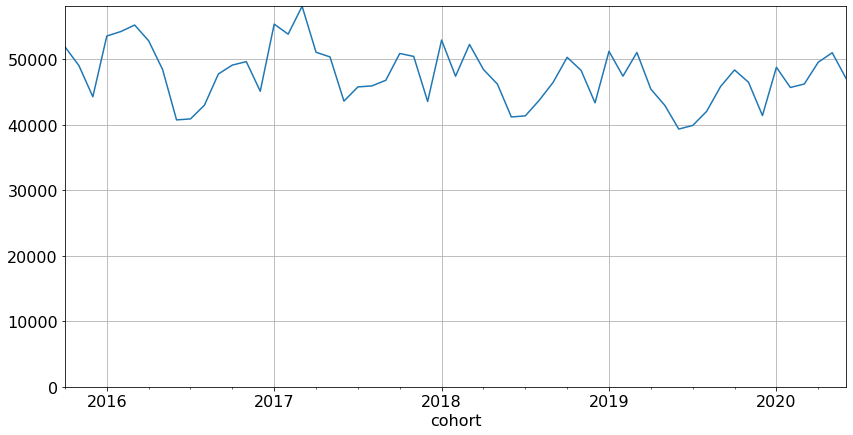

In [7]:
new_editors.loc["2015-10":, "enwiki"].plot()
plt.ylim(0);

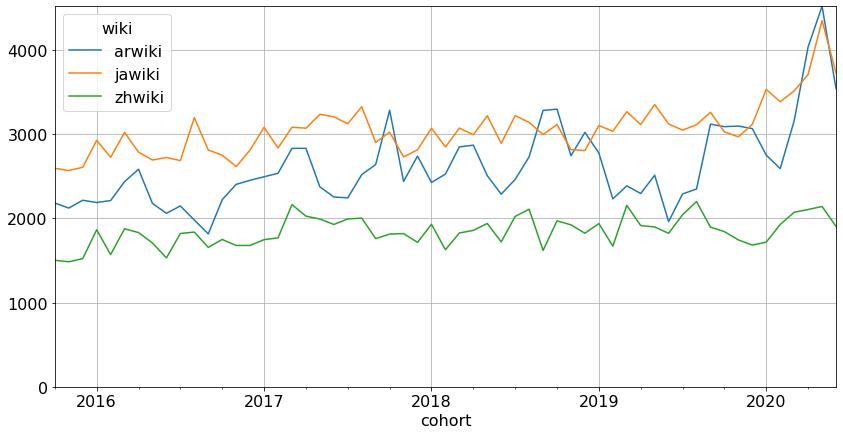

In [8]:
new_editors.loc["2015-10":, ["arwiki", "jawiki", "zhwiki"]].plot()
plt.ylim(0);